# Image segmentation

In [60]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
from skimage import io
from skimage.transform import resize
from sklearn.model_selection import train_test_split

## Data

source: https://www.kaggle.com/datasets/kmader/finding-lungs-in-ct-data

In [61]:
# load images
img_2d = sorted(glob.glob("data/2d_images" + "/*.tif"))
mask_2d = sorted(glob.glob("data/2d_masks" + "/*.tif"))
img_3d = sorted(glob.glob("data/3d_images/imgs" + "/*.nii"))
mask_3d = sorted(glob.glob("data/3d_images/masks" + "/*.nii"))

In [62]:
print(f"There are {len(img_2d)} 2d images and {len(mask_2d)} 2d masks.")

There are 267 2d images and 267 2d masks.


In [63]:
print(f"There are {len(img_3d)} 3d images and {len(mask_3d)} 3d masks.")

There are 4 3d images and 4 3d masks.


As there is a low number of 3d images and masks I will only work with 2d images.

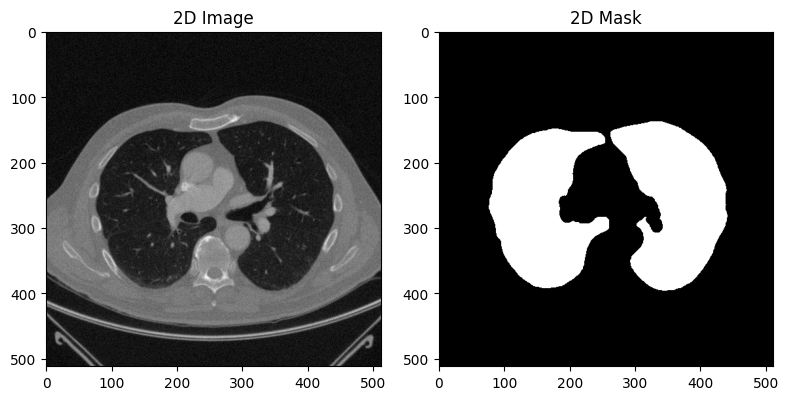

In [64]:
# I show the first image and its mask
img = np.array(Image.open(img_2d[0]))
mask = np.array(Image.open(mask_2d[0]))
# plot
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img, cmap='gray')
ax[0].set_title("2D Image")
ax[1].imshow(mask, cmap='gray')
ax[1].set_title("2D Mask")
plt.tight_layout()
plt.show()

## Model

I will explore different layers' structures and analyse their results.

In [65]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import ReduceLROnPlateau

### IMG_SIZE 128 -> 5 conv layers

In [66]:
IMG_SIZE = 128

In [67]:
def convert_to_array(path, size):
    # load
    data = io.imread(path)
    # resize to 1 channel
    data = resize(data, output_shape=(size, size, 1), preserve_range=True)
    # return the image to save it
    return data

def normalize_imgs(img_2d, mask_2d, size):
    ## create the np.array where we will save the data
    x_data, y_data = np.empty((2, len(img_2d), size, size, 1), dtype=np.float32)
    ## save the processed imgs and their masks
    for i, img_path in enumerate(img_2d):
        x_data[i] = convert_to_array(img_path, size)
    for i, mask_path in enumerate(mask_2d):
        y_data[i] = convert_to_array(mask_path, size)
    ## scale
    x_data /= 255
    y_data /= 255
    return x_data, y_data

In [68]:
x_data, y_data = normalize_imgs(img_2d, mask_2d, IMG_SIZE)
# first, we split data in train and test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

In [69]:
# Define input layer
inputs = Input(shape=(128, 128, 1))

# Encoder: 4 blocks conv + pool augmenting the filters
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

# Bottleneck layer
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

# Decoder: 4 blocks upsampling + conv reducing the filters
up4 = UpSampling2D(size=(2, 2))(conv3)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)

up5 = UpSampling2D(size=(2, 2))(conv4)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)

# Output layer
outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

# Build model
model_k3 = Model(inputs=inputs, outputs=outputs)

# Compile model
model_k3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_k3.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_22 (UpSampling2D) │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_23 (UpSampling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 128, 128, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,961 (722.50 KB)

 Trainable params: 184,961 (722.50 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, min_lr=1e-05)
# train model
history = model_k3.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=2, batch_size=32, callbacks=[reduce_lr])

Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 579ms/step - accuracy: 0.7120 - loss: 0.5483 - val_accuracy: 0.6966 - val_loss: 0.4076 - learning_rate: 0.0010
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 536ms/step - accuracy: 0.7115 - loss: 0.3754 - val_accuracy: 0.6966 - val_loss: 0.3155 - learning_rate: 0.0010


### IMG_SIZE 256 -> 7 conv layers

In [71]:
IMG_SIZE = 256

In [72]:
x_data, y_data = normalize_imgs(img_2d, mask_2d, IMG_SIZE)
# first, we split data in train and test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

In [73]:
# Define input layer
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

# Encoder: three blocks conv + pool augmenting the filters
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

# Bottleneck layer
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)

# Decoder: 3 blocks upsampling + conv reducing the filters
up5 = UpSampling2D(size=(2, 2))(conv4)
conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up5)

up6 = UpSampling2D(size=(2, 2))(conv5)
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)

up7 = UpSampling2D(size=(2, 2))(conv6)
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)

# Output layer
outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

# Build model
model_k1 = Model(inputs=inputs, outputs=outputs)

# Compile model
model_k1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_k1.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_24 (UpSampling2D) │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_25 (UpSampling2D) │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_26 (UpSampling2D) │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 256, 256, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 256, 256, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 775,169 (2.96 MB)

 Trainable params: 775,169 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, min_lr=1e-05)
# train model
history = model_k1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=2, batch_size=32, callbacks=[reduce_lr])

Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.7111 - loss: 0.5789 - val_accuracy: 0.7410 - val_loss: 0.4518 - learning_rate: 0.0010
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.7494 - loss: 0.3959 - val_accuracy: 0.7410 - val_loss: 0.3082 - learning_rate: 0.0010


#### 512 IMG_Size -> 9 conv layers

In [75]:
IMG_SIZE = 512

In [76]:
x_data, y_data = normalize_imgs(img_2d, mask_2d, IMG_SIZE)
# first, we split data in train and test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

In [77]:
# Define input layer
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

# Encoder: 4 blocks conv + pool augmenting the filters
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

# Bottleneck layer
conv5 = Conv2D(IMG_SIZE, (3, 3), activation='relu', padding='same')(pool4)

# Decoder: 4 blocks upsampling + conv reducing the filters
up6 = UpSampling2D(size=(2, 2))(conv5)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)

up7 = UpSampling2D(size=(2, 2))(conv6)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)

up8 = UpSampling2D(size=(2, 2))(conv7)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)

up9 = UpSampling2D(size=(2, 2))(conv8)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)

# Output layer
outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

# Build model
model_k2 = Model(inputs=inputs, outputs=outputs)

# Compile model
model_k2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_k1.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_24 (UpSampling2D) │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_25 (UpSampling2D) │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_26 (UpSampling2D) │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 256, 256, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 256, 256, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,325,509 (8.87 MB)

 Trainable params: 775,169 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,550,340 (5.91 MB)

In [78]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, min_lr=1e-05)
# train model
history = model_k2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=2, batch_size=32, callbacks=[reduce_lr])

Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 214s 24s/step - accuracy: 0.5804 - loss: 0.6427 - val_accuracy: 0.7752 - val_loss: 0.5527 - learning_rate: 0.0010
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 170s 23s/step - accuracy: 0.7648 - loss: 0.5221 - val_accuracy: 0.7752 - val_loss: 0.4162 - learning_rate: 0.0010


## Summary

After analysing the results, I conclude that
1. Both training loss and validation loss consistently decrease when additional epochs are applied (only 2 epochs were used due to computational constraints), which suggests that the models are learning;
2. Although training accuracy increases, validation accuracy remains stagnant. This suggests an overfitting risk: the model keep improving on training data but does not generalize better to unseen data.

In the following, these results are presented.

* IMG_SIZE = 128
    * epoch 1: accuracy: accuracy: 0.7120 - loss: 0.5483 - val_accuracy: 0.6966 - val_loss: 0.4076
    * epoch 2: accuracy: accuracy: 0.7115 - loss: 0.3754 - val_accuracy: 0.6966 - val_loss: 0.3155
* IMG_SIZE = 256
    * epoch 1: accuracy: accuracy: 0.7111 - loss: 0.5789 - val_accuracy: 0.7410 - val_loss: 0.4518
    * epoch 2: accuracy: accuracy: 0.7494 - loss: 0.3959 - val_accuracy: 0.7410 - val_loss: 0.3082
* IMG_SIZE = 512
    * epoch 1: accuracy: 0.5804 - loss: 0.6427 - val_accuracy: 0.7752 - val_loss: 0.5527
    * epoch 2: accuracy: 0.7648 - loss: 0.5221 - val_accuracy: 0.7752 - val_loss: 0.4162
